# CNN 이미지 분류 모델 - 실제 이미지 기반

## 프로젝트 개요

이 노트북은 **`shape_data/` 폴더에 있는 실제 이미지**를 읽어서  
CNN으로 분류하는 전체 파이프라인입니다.

### 데이터 구조
```
shape_data/
├── train/          ← 학습용 이미지
│   ├── 클래스A/    ← 폴더 이름 = 클래스 이름
│   ├── 클래스B/
│   └── ...         ← 폴더를 추가하면 클래스 자동 확장
└── val/            ← 검증/테스트용 이미지
    ├── 클래스A/
    ├── 클래스B/
    └── ...
```
> **클래스 추가 방법**: `train/`과 `val/` 아래에 새 폴더를 만들고 이미지를 넣으면 끝!  
> 코드가 폴더 구조를 자동으로 스캔하여 클래스를 인식합니다.

### 전체 파이프라인
```
1. 실제 이미지 데이터 로딩 및 탐색
2. PyTorch Dataset / DataLoader 구성
3. CNN 모델 아키텍처 정의
4. 모델 학습 (Training & Validation)
5. 학습 결과 시각화
6. 실제 이미지로 추론 (Inference)
```

---
## 0. Import & 환경 설정

In [1]:
import os
import random
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib
matplotlib.rcParams['font.family'] = 'AppleGothic'
matplotlib.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt

%matplotlib inline

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device: {device}")
print(f"PyTorch: {torch.__version__}")

Device: cpu
PyTorch: 2.2.2


---
## 1. 데이터 탐색

`shape_data/train/` 폴더 구조를 **자동 스캔**하여 클래스를 인식합니다.  
폴더 이름이 곧 클래스 이름이 됩니다.

In [2]:
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "shape_data")
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "val")

# 폴더 구조에서 클래스 자동 감지
CLASS_NAMES = sorted([
    d for d in os.listdir(TRAIN_DIR)
    if os.path.isdir(os.path.join(TRAIN_DIR, d)) and not d.startswith('.')
])
NUM_CLASSES = len(CLASS_NAMES)

IMG_EXTENSIONS = {'.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff', '.webp'}

print(f"데이터 경로: {DATA_DIR}")
print(f"감지된 클래스 ({NUM_CLASSES}개): {CLASS_NAMES}\n")

for split, split_dir in [("train", TRAIN_DIR), ("val", VAL_DIR)]:
    print(f"[{split}]")
    for cls in CLASS_NAMES:
        cls_dir = os.path.join(split_dir, cls)
        if os.path.isdir(cls_dir):
            count = len([f for f in os.listdir(cls_dir)
                        if os.path.splitext(f)[1].lower() in IMG_EXTENSIONS])
            print(f"  {cls:15s}: {count}장")
    print()

데이터 경로: /Users/roywoojinkim/Projects/pro1 /CNN/shape_data
감지된 클래스 (5개): ['circle', 'cross', 'diamond', 'square', 'triangle']

[train]
  circle         : 500장
  cross          : 500장
  diamond        : 500장
  square         : 500장
  triangle       : 500장

[val]
  circle         : 100장
  cross          : 100장
  diamond        : 100장
  square         : 100장
  triangle       : 100장



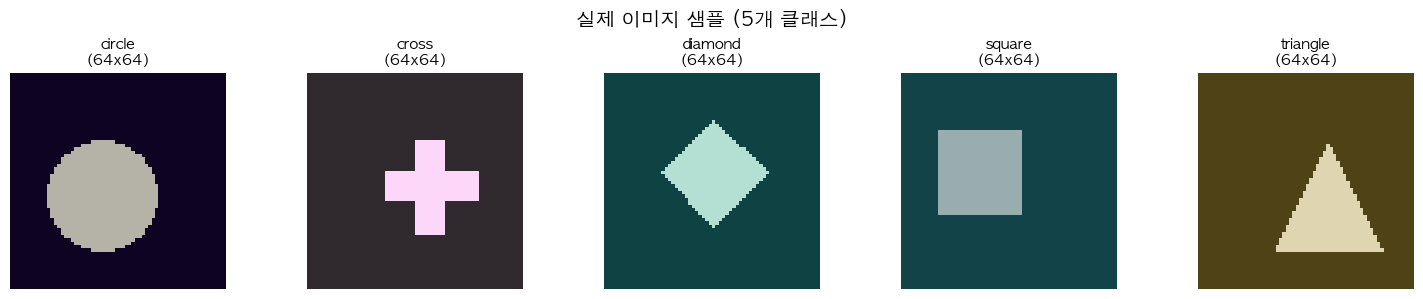

In [3]:
# 각 클래스별 실제 이미지 샘플 시각화
fig, axes = plt.subplots(1, NUM_CLASSES, figsize=(3 * NUM_CLASSES, 3))
if NUM_CLASSES == 1:
    axes = [axes]

for ax, cls in zip(axes, CLASS_NAMES):
    cls_dir = os.path.join(TRAIN_DIR, cls)
    img_files = [f for f in sorted(os.listdir(cls_dir))
                 if os.path.splitext(f)[1].lower() in IMG_EXTENSIONS]
    if img_files:
        img = Image.open(os.path.join(cls_dir, img_files[0])).convert("RGB")
        ax.imshow(np.array(img))
        ax.set_title(f"{cls}\n({img.size[0]}x{img.size[1]})", fontsize=11)
    ax.axis("off")

plt.suptitle(f"실제 이미지 샘플 ({NUM_CLASSES}개 클래스)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

---
## 2. PyTorch Dataset / DataLoader

- 폴더 구조에서 이미지를 자동으로 읽어옴
- 이미지 크기가 다를 수 있으므로 **target_size로 리사이즈** (배치 구성에 필요)
- 지원 확장자: png, jpg, jpeg, bmp, gif, tiff, webp

### 이미지 → 텐서 변환
```
실제 이미지 파일 (다양한 크기)
    ↓ Image.open() + .convert("RGB")
PIL Image (H, W, 3)
    ↓ .resize(target_size)
PIL Image (64, 64, 3)   ← 통일된 크기
    ↓ np.array() + permute + / 255.0
Tensor (3, 64, 64) [0.0 ~ 1.0]
```

In [4]:
class ImageFolderDataset(Dataset):
    """
    폴더 구조에서 실제 이미지를 읽어오는 Dataset
    
    root_dir/
    ├── class_a/  → label 0
    ├── class_b/  → label 1
    └── ...       → label N
    """

    def __init__(self, root_dir, class_names, target_size=(64, 64)):
        self.samples = []
        self.target_size = target_size
        for label, cls in enumerate(class_names):
            cls_dir = os.path.join(root_dir, cls)
            if not os.path.isdir(cls_dir):
                continue
            for fname in sorted(os.listdir(cls_dir)):
                if os.path.splitext(fname)[1].lower() in IMG_EXTENSIONS:
                    self.samples.append((os.path.join(cls_dir, fname), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.target_size:
            img = img.resize(self.target_size, Image.BILINEAR)
        tensor = torch.from_numpy(np.array(img)).permute(2, 0, 1).float() / 255.0
        return tensor, label


IMG_SIZE = 64

train_ds = ImageFolderDataset(TRAIN_DIR, CLASS_NAMES, target_size=(IMG_SIZE, IMG_SIZE))
val_ds = ImageFolderDataset(VAL_DIR, CLASS_NAMES, target_size=(IMG_SIZE, IMG_SIZE))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

print(f"Train: {len(train_ds)}장, Val: {len(val_ds)}장")
print(f"클래스: {CLASS_NAMES} (총 {NUM_CLASSES}개)")

imgs, labels = next(iter(train_loader))
print(f"배치 shape: {imgs.shape}")
print(f"라벨 예시: {labels[:8].tolist()}")

Train: 2500장, Val: 500장
클래스: ['circle', 'cross', 'diamond', 'square', 'triangle'] (총 5개)
배치 shape: torch.Size([32, 3, 64, 64])
라벨 예시: [2, 3, 4, 0, 1, 1, 0, 4]


---
## 3. CNN 모델 정의

```
입력: (3, H, W)
  [Block 1] Conv2d(3→16) → BN → ReLU → MaxPool(2)
  [Block 2] Conv2d(16→32) → BN → ReLU → MaxPool(2)
  [Block 3] Conv2d(32→64) → BN → ReLU → MaxPool(2)
  AdaptiveAvgPool2d(4,4) → Flatten(1024)
  Linear(1024→128) → ReLU → Dropout(0.3) → Linear(128→N)
출력: N개 클래스 로짓
```

| 레이어 | 역할 |
|--------|------|
| **Conv2d** | 3x3 필터로 특징 추출 |
| **BatchNorm2d** | 학습 안정화 |
| **MaxPool2d(2)** | 크기 1/2 축소 |
| **AdaptiveAvgPool2d(4)** | 어떤 크기든 4x4로 통일 |
| **Dropout(0.3)** | 과적합 방지 |

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(True), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(True), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(True), nn.MaxPool2d(2),
        )
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 128), nn.ReLU(True), nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        return self.classifier(x)


model = SimpleCNN(num_classes=NUM_CLASSES).to(device)
print(model)
print(f"\n총 파라미터: {sum(p.numel() for p in model.parameters()):,}개 | 클래스: {NUM_CLASSES}개")

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(4, 4))
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
   

---
## 4. 모델 학습

| 설정 | 값 |
|------|-----|
| Epochs | 15 |
| LR | 0.001 |
| Batch | 32 |
| Optimizer | Adam |
| Loss | CrossEntropyLoss |

In [6]:
EPOCHS = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
history = {"train_loss": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model(imgs), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    train_loss = running_loss / len(train_ds)

    model.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            val_loss += criterion(outputs, labels).item() * imgs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
    val_loss /= len(val_ds)
    val_acc = correct / len(val_ds) * 100

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    print(f"Epoch {epoch:2d}/{EPOCHS} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.1f}%")

print(f"\n최종 Validation Accuracy: {history['val_acc'][-1]:.1f}%")

Epoch  1/15 | train_loss=0.5501 | val_loss=0.0531 | val_acc=99.8%


Epoch  2/15 | train_loss=0.0399 | val_loss=0.0248 | val_acc=99.2%


Epoch  3/15 | train_loss=0.0167 | val_loss=0.0196 | val_acc=99.2%


Epoch  4/15 | train_loss=0.0086 | val_loss=0.0024 | val_acc=100.0%


Epoch  5/15 | train_loss=0.0042 | val_loss=0.0030 | val_acc=100.0%


Epoch  6/15 | train_loss=0.0049 | val_loss=0.0047 | val_acc=100.0%


Epoch  7/15 | train_loss=0.0088 | val_loss=0.0050 | val_acc=99.6%


Epoch  8/15 | train_loss=0.0025 | val_loss=0.0008 | val_acc=100.0%


Epoch  9/15 | train_loss=0.0035 | val_loss=0.0007 | val_acc=100.0%


Epoch 10/15 | train_loss=0.0031 | val_loss=0.0043 | val_acc=99.8%


Epoch 11/15 | train_loss=0.0019 | val_loss=0.0006 | val_acc=100.0%


Epoch 12/15 | train_loss=0.0008 | val_loss=0.0002 | val_acc=100.0%


Epoch 13/15 | train_loss=0.0004 | val_loss=0.0001 | val_acc=100.0%


Epoch 14/15 | train_loss=0.0003 | val_loss=0.0001 | val_acc=100.0%


Epoch 15/15 | train_loss=0.0003 | val_loss=0.0011 | val_acc=100.0%

최종 Validation Accuracy: 100.0%


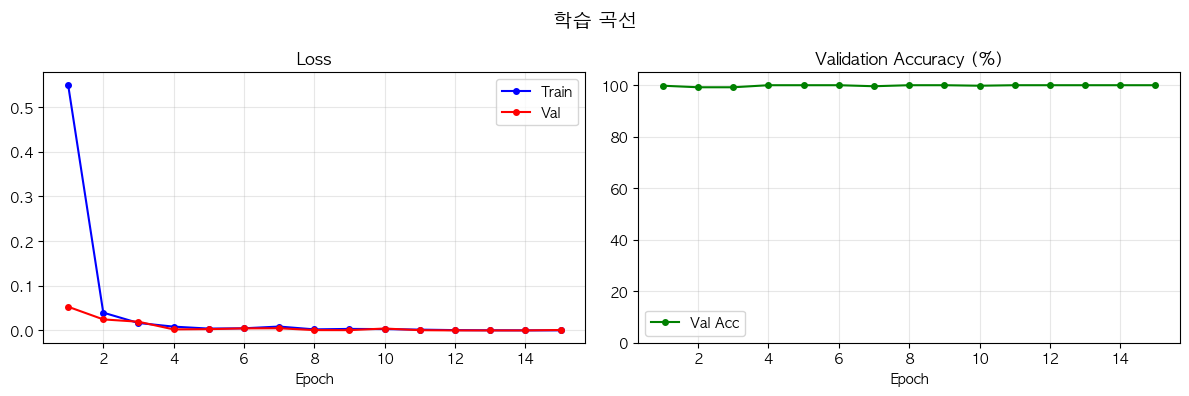

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ep = range(1, EPOCHS + 1)
ax1.plot(ep, history["train_loss"], "b-o", ms=4, label="Train"); ax1.plot(ep, history["val_loss"], "r-o", ms=4, label="Val")
ax1.set_title("Loss"); ax1.set_xlabel("Epoch"); ax1.legend(); ax1.grid(True, alpha=0.3)
ax2.plot(ep, history["val_acc"], "g-o", ms=4, label="Val Acc")
ax2.set_title("Validation Accuracy (%)"); ax2.set_xlabel("Epoch"); ax2.set_ylim(0, 105); ax2.legend(); ax2.grid(True, alpha=0.3)
plt.suptitle("학습 곡선", fontsize=14, fontweight="bold"); plt.tight_layout(); plt.show()

In [8]:
model_path = os.path.join(DATA_DIR, "cnn_model.pth")
torch.save(model.state_dict(), model_path)
print(f"모델 저장 완료: {model_path}")

모델 저장 완료: /Users/roywoojinkim/Projects/pro1 /CNN/shape_data/cnn_model.pth


---
## 5. 추론 (Inference) - 실제 이미지

학습된 모델을 로드하여 **val 폴더의 실제 이미지**로 추론합니다.

In [9]:
inference_model = SimpleCNN(num_classes=NUM_CLASSES).to(device)
inference_model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
inference_model.eval()
print(f"모델 로드 완료 (클래스 {NUM_CLASSES}개: {CLASS_NAMES})")

모델 로드 완료 (클래스 5개: ['circle', 'cross', 'diamond', 'square', 'triangle'])


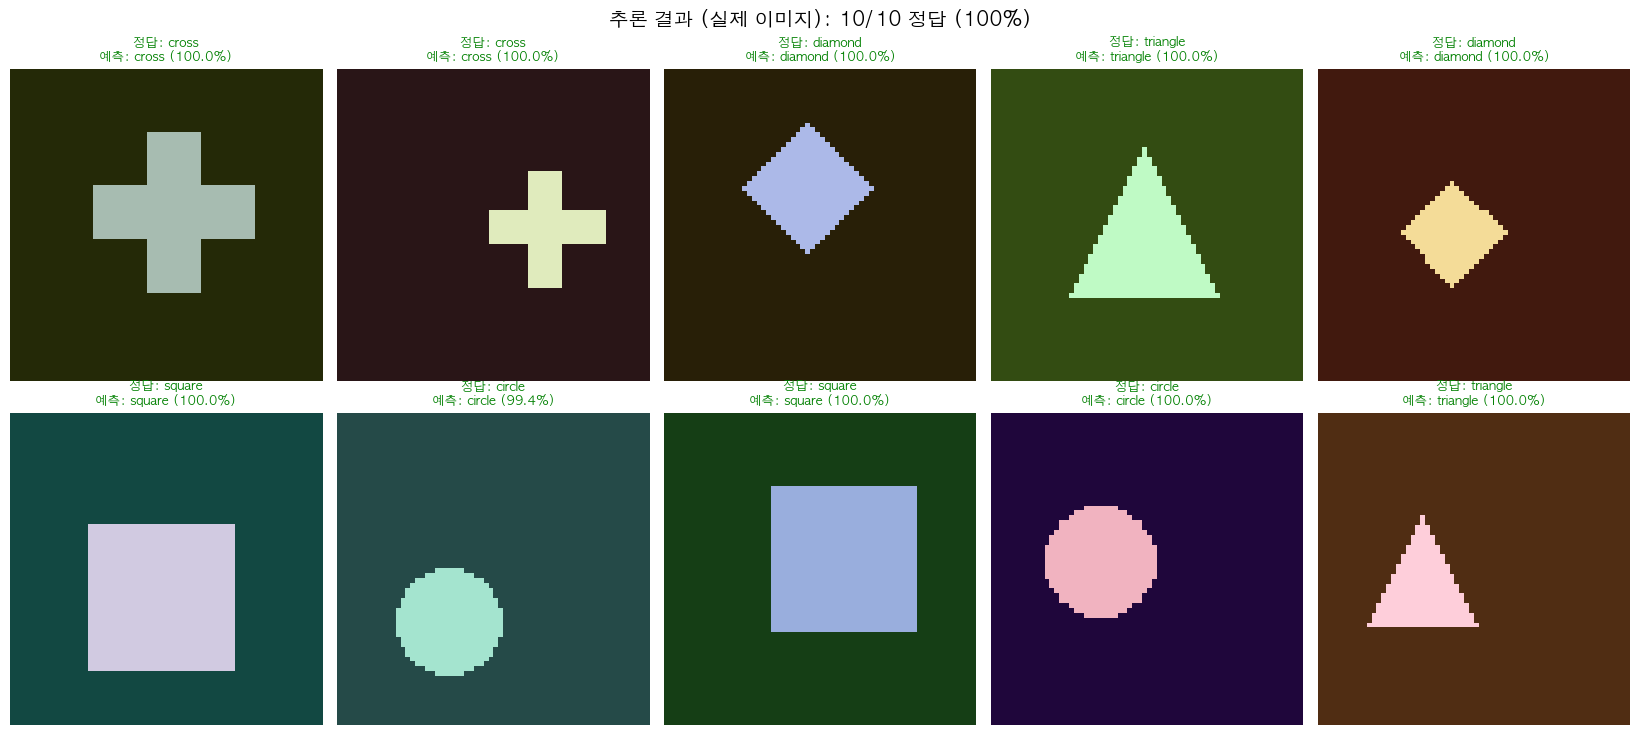


추론 정확도: 10/10 (100%)


In [10]:
# val 폴더에서 클래스별 2장씩 랜덤 추출하여 추론
test_samples = []
for cls in CLASS_NAMES:
    cls_dir = os.path.join(VAL_DIR, cls)
    img_files = [f for f in os.listdir(cls_dir) if os.path.splitext(f)[1].lower() in IMG_EXTENSIONS]
    for fname in random.sample(img_files, min(2, len(img_files))):
        test_samples.append((os.path.join(cls_dir, fname), cls))
random.shuffle(test_samples)
n_test = len(test_samples)

ncols = min(5, n_test)
nrows = (n_test + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(3.3 * ncols, 3.8 * nrows))
if n_test == 1: axes = np.array([axes])
axes_flat = list(axes.flat)

correct = 0
for i, (ax, (img_path, true_cls)) in enumerate(zip(axes_flat, test_samples)):
    img = Image.open(img_path).convert("RGB")
    img_resized = img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
    tensor = torch.from_numpy(np.array(img_resized)).permute(2, 0, 1).float() / 255.0
    tensor = tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        probs = torch.softmax(inference_model(tensor), dim=1)
        pred_idx = probs.argmax(1).item()
        confidence = probs[0, pred_idx].item() * 100

    pred_cls = CLASS_NAMES[pred_idx]
    is_correct = pred_cls == true_cls
    correct += int(is_correct)

    ax.imshow(np.array(img))
    ax.set_title(f"정답: {true_cls}\n예측: {pred_cls} ({confidence:.1f}%)",
                 color="green" if is_correct else "red", fontsize=9)
    ax.axis("off")

for j in range(i + 1, nrows * ncols):
    axes_flat[j].axis("off")

fig.suptitle(f"추론 결과 (실제 이미지): {correct}/{n_test} 정답 ({correct/n_test*100:.0f}%)",
             fontsize=14, fontweight="bold")
plt.tight_layout(); plt.show()
print(f"\n추론 정확도: {correct}/{n_test} ({correct/n_test*100:.0f}%)")

---
## 6. 단일 이미지 추론 함수

In [11]:
def predict_image(model, image_path, class_names, img_size=64, device=device):
    """이미지 파일 경로 → 예측 클래스 + 확률"""
    model.eval()
    img = Image.open(image_path).convert("RGB").resize((img_size, img_size), Image.BILINEAR)
    tensor = torch.from_numpy(np.array(img)).permute(2, 0, 1).float() / 255.0
    tensor = tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        probs = torch.softmax(model(tensor), dim=1)[0]
    probs_dict = {cls: f"{probs[i].item()*100:.1f}%" for i, cls in enumerate(class_names)}
    return class_names[probs.argmax().item()], probs_dict


# val 폴더에서 각 클래스 1장씩 테스트
print("=" * 65)
for cls in CLASS_NAMES:
    cls_dir = os.path.join(VAL_DIR, cls)
    img_files = [f for f in os.listdir(cls_dir) if os.path.splitext(f)[1].lower() in IMG_EXTENSIONS]
    if img_files:
        path = os.path.join(cls_dir, random.choice(img_files))
        pred, probs = predict_image(inference_model, path, CLASS_NAMES)
        mark = "O" if pred == cls else "X"
        print(f"[{mark}] 정답: {cls:10s} → 예측: {pred:10s} | {probs}")
print("=" * 65)

[O] 정답: circle     → 예측: circle     | {'circle': '100.0%', 'cross': '0.0%', 'diamond': '0.0%', 'square': '0.0%', 'triangle': '0.0%'}
[O] 정답: cross      → 예측: cross      | {'circle': '0.0%', 'cross': '100.0%', 'diamond': '0.0%', 'square': '0.0%', 'triangle': '0.0%'}
[O] 정답: diamond    → 예측: diamond    | {'circle': '0.0%', 'cross': '0.0%', 'diamond': '100.0%', 'square': '0.0%', 'triangle': '0.0%'}
[O] 정답: square     → 예측: square     | {'circle': '0.0%', 'cross': '0.0%', 'diamond': '0.0%', 'square': '100.0%', 'triangle': '0.0%'}
[O] 정답: triangle   → 예측: triangle   | {'circle': '0.0%', 'cross': '0.0%', 'diamond': '0.0%', 'square': '0.0%', 'triangle': '100.0%'}


---
## 7. 전체 Validation 세트 평가

In [12]:
inference_model.eval()
cls_correct = {c: 0 for c in CLASS_NAMES}
cls_total = {c: 0 for c in CLASS_NAMES}
total_ok = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = inference_model(imgs).argmax(1)
        for p, l in zip(preds, labels):
            c = CLASS_NAMES[l.item()]
            cls_total[c] += 1
            if p.item() == l.item():
                cls_correct[c] += 1
                total_ok += 1

print(f"{'클래스':12s} | {'정답':>5s} / {'전체':>5s} | {'정확도':>7s}")
print("-" * 42)
for c in CLASS_NAMES:
    acc = cls_correct[c] / cls_total[c] * 100 if cls_total[c] else 0
    print(f"{c:12s} | {cls_correct[c]:5d} / {cls_total[c]:5d} | {acc:6.1f}%")
print("-" * 42)
print(f"{'TOTAL':12s} | {total_ok:5d} / {len(val_ds):5d} | {total_ok/len(val_ds)*100:6.1f}%")

클래스          |    정답 /    전체 |     정확도
------------------------------------------
circle       |   100 /   100 |  100.0%
cross        |   100 /   100 |  100.0%
diamond      |   100 /   100 |  100.0%
square       |   100 /   100 |  100.0%
triangle     |   100 /   100 |  100.0%
------------------------------------------
TOTAL        |   500 /   500 |  100.0%


---
## 요약

| 단계 | 내용 |
|------|------|
| 데이터 | `shape_data/` 폴더의 **실제 이미지** 사용 (폴더명 = 클래스명) |
| 클래스 감지 | 폴더 구조 자동 스캔 → 클래스 수/이름 자동 결정 |
| 모델 | 3-layer CNN + AdaptiveAvgPool |
| 학습 | 15 에폭, Adam, CrossEntropyLoss |
| 추론 | val 폴더의 실제 이미지로 테스트 |

### 새 데이터셋 적용
1. `shape_data/train/새클래스/` 폴더에 이미지 넣기
2. `shape_data/val/새클래스/` 폴더에 이미지 넣기
3. 노트북 처음부터 실행 → 끝! (코드 수정 없음)